In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
blue = '#1F449C'
pink = '#E57A77'

In [3]:
model = pyhf.Model(
        {'channels': [{'name': 'singlechannel',
        'samples': [
        {'name': 'signal',
        'data': [10, 20, 10],
        'modifiers': [
            {'name': 'mu', 'type': 'normfactor', 'data': None},
            {'name': 'mu2', 'type': 'normfactor', 'data': None}]},
        {'name': 'background',
        'data': [120, 110, 100],
        'modifiers': [
            # Normalisation Uncertainty / Normal
            {'name': 'normSys', "type": "normsys", "data": {"hi": 0.95, "lo": 1.05}},
            # Staterror / Normal
            {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
            # Uncorrelated / Poisson
            {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]}
            ]}]}]
            }
        )

data = [0, 15, 100]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    'mu2': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

In [32]:
# with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
#     spec = json.load(serialized)

# workspace = pyhf.Workspace(spec)
# model = workspace.model()

# data = workspace.data(model, include_auxdata=False)

# unconstr_priors = {
#     'ttbarXsec': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]}
# }

In [9]:
priorDict_conjugate = prepare_inference.build_priorDict_conjugate(model, unconstr_priors)
len(priorDict_conjugate.keys())

5

In [ ]:
with pm.Model():
    pars = pm.HalfNormal('test', sigma=0.2)
    print(pars.type)
    flat = pm.Flat('flat')
    print(flat.type)

    pars_combined = []
    pars_combined.extend(pm.HalfNormal('testt', sigma=0.2))

In [4]:
prior_dict = prepare_inference.build_priorDict_conjugate(model, unconstr_priors)

In [6]:
pars_combined = []

with pm.Model():

    for name, specs in  prior_dict.items():

        if specs['type'] == 'HalfNormal_Unconstrained':
            pars_combined.extend(pm.HalfNormal(name, sigma=specs['sigma']))   
        
        if specs['type'] == 'Gamma_Unconstrained':
            pars_combined.extend(pm.Gamma(name, alpha=specs['alpha'], beta=specs['beta']))


        
        if specs['type'] == 'Normal':
            pars_combined.extend(pm.Normal(name, mu=specs['mu'], sigma=specs['sigma']))
        
        if specs['type'] == 'Gamma':
            # pars_combined.extend(pm.Gamma(name, alpha=specs['alpha_beta'], beta=specs['alpha_beta']))
            pars_combined.extend([pm.Flat(name)])
            print(name)


    # pars_combined.extend(pm.Flat('test'))
    pars_combined = pt.as_tensor_variable(pars_combined)
    print(pars_combined)

uncorr_bkg
MakeVector{dtype='float64'}.0


In [ ]:
pyhf.set_backend('numpy')
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=1_00, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1_00)

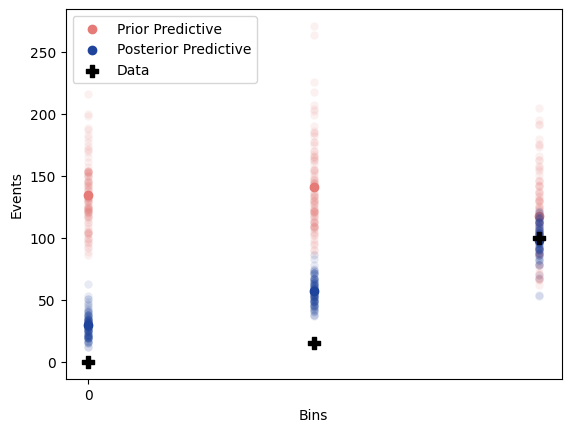

In [7]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)